# Master notebook for evaluating  performaces


In [1]:
import os
import glob
import tqdm
import numpy as np
import mplhep as hep
import awkward as ak
import matplotlib.pyplot as plt
from hydra import compose, initialize
from omegaconf import OmegaConf

from enreg.tools import general as g
from enreg.tools.metrics import (
    regression_evaluator as re,
    decay_mode_evaluator as dme,
    tagger_evaluator as te
)

with initialize(version_base=None, config_path="../enreg/config/", job_name="test_app"):
    cfg = compose(config_name="benchmarking")

hep.style.use(hep.styles.CMS)

In [2]:
OUTPUT_DIR = directories['OUTPUT_DIR']
BASE_DATA_DIR = directories['BASE_DATA_DIR']

In [3]:
# Data directory
SAMPLE_DIR = {
    "z_test": os.path.join(BASE_DATA_DIR, "z_test.parquet"),
    "zh_test": os.path.join(BASE_DATA_DIR, "zh_test.parquet"),
    "qq_test": os.path.join(BASE_DATA_DIR, "qq_test.parquet"),
    "z_train": os.path.join(BASE_DATA_DIR, "z_train.parquet"),
    "zh_train": os.path.join(BASE_DATA_DIR, "zh_train.parquet"),
    "qq_train": os.path.join(BASE_DATA_DIR, "qq_train.parquet"),
}

In [4]:
def train_data_loader(key): # DO I NEED THIS? create_reco_entries WORKS WITHOUT IT RN?
    """
    Returns ak.Array
    """
    return g.load_all_data(SAMPLE_DIR[key])

# z_test_data = train_data_loader("z_test")
zh_test_data = train_data_loader("zh_test")
# qq_test_data = train_data_loader("qq_test")

[1/1] Loading from /scratch/persistent/laurits/ml-tau/20241002_Training_ntuples_geq20gev/zh_test.parquet
Input data loaded


In [5]:
def create_reco_entries(base_dir, key,  output_dir):
    """
    Creates reconstruced stuffs
    """
    data = ak.from_parquet(base_dir, columns=['reco_jet_p4s', "gen_jet_tau_p4s"])
    data = ak.Array({k: data[k] for k in data.fields})
    data_to_save = {
        "reco_jet_pt": g.reinitialize_p4(data.reco_jet_p4s).pt,
        "gen_tau_pt": g.reinitialize_p4(data.gen_jet_tau_p4s).pt
    }
    output_dir = os.path.join(output_dir, "recoJet")
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f"{key}.parquet")
    print(f"Saving to {output_path}")
    ak.to_parquet(ak.Record(data_to_save), output_path, row_group_size=1024)

for idx, (key, value) in enumerate(SAMPLE_DIR.items()):
    if idx == 2:
        break
    else:
        create_reco_entries(SAMPLE_DIR[key], key, OUTPUT_DIR)

Saving to /home/hardiveski/ml-tau-en-reg/notebooks/z_temp_output/recoJet/z_test.parquet
Saving to /home/hardiveski/ml-tau-en-reg/notebooks/z_temp_output/recoJet/zh_test.parquet


In [6]:
BASE_TRAINING_DIR = directories['BASE_TRAINING_DIR']

# Training types
training_types = ['20201204_ParT_ntrain_v2', '20201206_updated_DM_training',
                  '20201211_ParT_no_PMHA' ,'20241220_unfreeze_from_start',
                  '20241204_ParT_ntrain','20250109_OmniParT_2GPT_layers']
# Model parameters
training_types = evaluating['training_types']
model_versions = evaluating['model_types']['version']
train_fracs = evaluating['model_types']['train_frac']
tasks = evaluating['model_types']['tasks']

models = evaluating['model_types']['models']
model_test_type = evaluating['model_types']['z_OR_zh_test']

In [8]:
def model_loader(base_dir, training, v, fraction, task, model, test_type):
    full_directory = os.path.join(base_dir, training, v, fraction, task, model, test_type + '.parquet')
    return g.load_all_data(full_directory)

def load_model_data(base_dir, training, versions, fractions, tasks, models, test_type):
    """
    Dynamically load data for specified model parameters.
    Args:
    - base_dir (str): Base directory for models.
    - versions (str or list): Single version or list of versions to process.
    - fractions (str or list): Single fraction or list of fractions to process.
    - tasks (str or list): Single task or list of tasks to process.
    - models (str or list): Single model or list of models to process.
    - test_type (str or list): Test type (e.g., 'zh_test').
    Returns:
    - dict: Loaded data indexed by parameter combinations.
    """
    # Convert inputs into lists if they aren't already lists
    if isinstance(training, str):
        training = [training]
    if isinstance(versions, str):
        versions = [versions]
    if isinstance(fractions, str):
        fractions = [fractions]
    if isinstance(tasks, str):
        tasks = [tasks]
    if isinstance(models, str):
        models = [models]
    if isinstance(test_type, str):
        test_type = [test_type]
    
    loaded_data = {}
    # Loop over all combinations of the parameters
    for tra in training:
        for v in versions:
            for fraction in fractions:
                for task in tasks:
                    for model in models:
                        for test in test_type:
                            dataset_name = f"{tra}_{model}_{v}_{fraction}_{task}_{test}"
                            try:
                                print(f"Loading data for {dataset_name}")
                                loaded_data[dataset_name] = model_loader(base_dir, tra, v,
                                                                         fraction, task, model, test)
                            except ValueError as e:
                                print(f"Failed to load {dataset_name}: {e}")
    return loaded_data

# Example: Load data for ParticleTransformer with single version and task
loaded_data = load_model_data(
    BASE_TRAINING_DIR,
    training_types[0],
    version[0],
    train_frac[0],
    tasks[0],
    models[0],
    model_test_type[1]
)

# Access specific datasets after loading
PT_jet_regression = loaded_data.get("20201204_ParT_ntrain_v2_ParticleTransformer_v1_trainfrac_1e4_jet_regression_zh_test")
# PT_dm_multiclass = loaded_data.get("ParticleTransformer_v1_trainfrac_1e4_dm_multiclass_z_test")
print(PT_jet_regression)


Loading data for 20201204_ParT_ntrain_v2_ParticleTransformer_v1_trainfrac_1e4_jet_regression_zh_test
[1/1] Loading from /home/laurits/ml-tau-en-reg/training-outputs/20201204_ParT_ntrain_v2/v1/trainfrac_1e4/jet_regression/ParticleTransformer/zh_test.parquet
Input data loaded
[{jet_regression: {pred: 46.7, target: 50}}, ..., {jet_regression: {...}}]


In [9]:
input_loc = "/home/laurits/ml-tau-en-reg/training-outputs/20240921_recoPtCut_removed_samples/v1/jet_regression/LorentzNet/zh_test.parquet"
print("File exists:", os.path.exists(input_loc))
print("Is it a file?:", os.path.isfile(input_loc))
print("Can we read the file?:", os.access(input_loc, os.R_OK))

File exists: False
Is it a file?: False
Can we read the file?: False


In [10]:
PT_data = g.load_all_data("/home/laurits/ml-tau-en-reg/training-outputs/20201204_ParT_ntrain_v2/v1/trainfrac_1e4/jet_regression/ParticleTransformer/zh_test.parquet")
# LN_data = g.load_all_data("/home/laurits/ml-tau-en-reg/training-outputs/20240921_recoPtCut_removed_samples/v1/jet_regression/LorentzNet/zh_test.parquet")
# DS_data = g.load_all_data("/home/laurits/ml-tau-en-reg/training-outputs/20240921_recoPtCut_removed_samples/v1/jet_regression/DeepSet/zh_test.parquet")
# hps_data = g.load_all_data("/home/laurits/HPS_recoCut0_ntuples/zh.parquet")
# recoJet_data = g.load_all_data("/home/laurits/ntuples/20240924_lowered_recoPtCut/recoJet/zh.parquet")

[1/1] Loading from /home/laurits/ml-tau-en-reg/training-outputs/20201204_ParT_ntrain_v2/v1/trainfrac_1e4/jet_regression/ParticleTransformer/zh_test.parquet
Input data loaded


In [11]:
# hpsPlus_mask = hps_data.true_decay_mode == hps_data.pred_decay_mode
cfg.metrics.regression.ratio_plot.resolution_plot.ylim = [0, 0.2]
cfg.metrics.regression.ratio_plot.response_plot.ylim = [0.0, 2.0]

In [12]:
evaluators = {
    # "HPS_":  re.RegressionEvaluator(hps_data.pred_pt[hpsPlus_mask], hps_data.true_pt[hpsPlus_mask], cfg.metrics.regression, "zh", "HPS_"),
    # "RecoJet":  re.RegressionEvaluator(recoJet_data.reco_jet_pt, recoJet_data.gen_tau_pt, cfg.metrics.regression, "zh", "RecoJet"),
    "PT":   re.RegressionEvaluator(PT_data.jet_regression.pred, PT_data.jet_regression.target, cfg.metrics.regression, "zh", "ParticleTransformer"),
    # "LN":  re.RegressionEvaluator(LN_data.jet_regression.pred, LN_data.jet_regression.target, cfg.metrics.regression, "zh", "LorentzNet"),
    # "DS":  re.RegressionEvaluator(DS_data.jet_regression.pred, DS_data.jet_regression.target, cfg.metrics.regression, "zh", "DeepSet")
}

In [15]:
os.makedirs(OUTPUT_DIR+'plots', exist_ok=True)
rme = re.RegressionMultiEvaluator(OUTPUT_DIR+'plots', cfg.metrics.regression, "zh")

rme.combine_results([evaluator for evaluator in evaluators.values()])
rme.save()

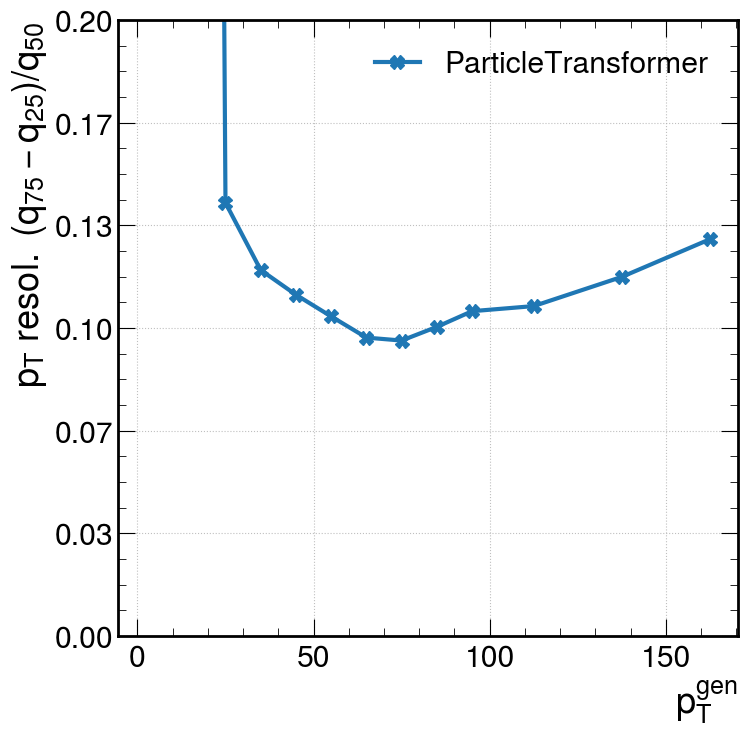

In [16]:
rme.resolution_lineplot.fig

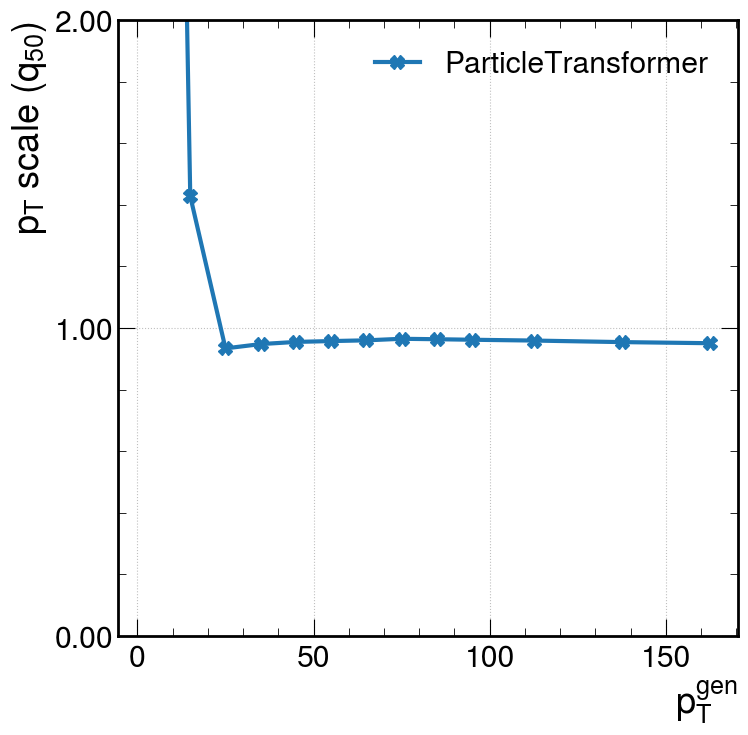

In [17]:
rme.response_lineplot.fig

## Decay mode performances

In [ ]:
data = {sample: g.load_all_data(os.path.join(BASE_MODEL_DIR, sample + ".parquet")) for sample in cfg.comparison_samples}

for algorithm, algo_info in cfg.metrics.dm_reconstruction.algorithms.items():
    for signal_sample in cfg.metrics.dm_reconstruction.signal_samples:
        sig_info_data = data[signal_sample]
        if not os.path.exists(os.path.join(algo_info.data_dir, signal_sample + ".parquet")):
            continue
        sig_data = g.load_all_data(os.path.join(algo_info.data_dir, signal_sample + ".parquet"))

        output_dir = "output_plots_dm"
        evaluator = dme.DecayModeEvaluator(sig_data.dm_multiclass.pred, sig_data.dm_multiclass.target, output_dir, signal_sample, algorithm)
        evaluator.save_performance()